In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nnfl-lab3/word2vec_tweets.txt
/kaggle/input/nnfl-lab3/__results__.html
/kaggle/input/nnfl-lab3/__output__.json
/kaggle/input/nnfl-lab3/custom.css
/kaggle/input/nnfl-lab3/__notebook__.ipynb
/kaggle/input/nnfl-lab3/2018A7PS0225G.h5
/kaggle/input/nnfl-lab3/__results___files/__results___28_0.png
/kaggle/input/nnfl-lab3/__results___files/__results___29_0.png
/kaggle/input/nnfl-lab-3/lab3_train.csv
/kaggle/input/nnfl-lab-3/lab3_test.csv
/kaggle/input/nnfl-lab-3/sample_submission.csv


In [2]:
import numpy as np
import pandas as pd 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import string
from keras.preprocessing.text import Tokenizer

In [3]:
df=pd.read_csv("../input/nnfl-lab-3/lab3_train.csv")

In [4]:
df

,index,text,class
0,0,(['Due to the large numbers of transcription f...,1
1,1,(['The human daily activity category represent...,1
2,2,(['A severe pneumonia-associated respiratory s...,2
3,3,(['We recently proposed that human memory syst...,1
4,4,(['We present a deep reinforcement learning fr...,1
...,...,...,...
29995,29995,"([], 'Coronavirus (COVID-19) infection-induced...",2
29996,29996,"([""Brain-computer interfaces (BCI) have been s...",5
29997,29997,"([""The purpose of this study was to develop a ...",4
29998,29998,(['Interprofessional team training is needed t...,4


In [5]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

tweets = list()
lines=df['text'].values.tolist()

for line in lines:
    tokens=word_tokenize(line)
    tokens=[w.lower() for w in tokens]
    table=str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]
  
    
    words = [word for word in stripped if word.isalpha()]
    
    stop_words=set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    tweets.append(words)
    

In [6]:
EMBEDDING_DIM = 200

In [7]:
import gensim

model=gensim.models.Word2Vec(sentences=tweets,size=EMBEDDING_DIM,window=5,workers=4,min_count=1)

words=list(model.wv.vocab)
print(len(words))

78881


In [8]:
filename = 'word2vec_tweets.txt'
model.wv.save_word2vec_format(filename,binary=False)

In [9]:
embeddings_index={}
f=open(os.path.join('','word2vec_tweets.txt'),encoding="utf-8")

In [10]:
for line in f:
    values=line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [11]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

In [12]:
word_index=tokenizer_obj.word_index
print(len(word_index))

78881


In [13]:
max_len=0
for line in df['text'].values:
    line_len=len(line.split())
    max_len=max(max_len,line_len) 

In [14]:
print(max_len)

1103


In [15]:
#look out for values
max_length=1200

In [16]:
from keras.preprocessing.sequence import pad_sequences 

review_pad = pad_sequences(sequences,maxlen=max_length)
sentiment = pd.get_dummies(df['class'].values)
print(review_pad.shape)
print(sentiment.shape)

(30000, 1200)
(30000, 5)


In [17]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [18]:
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
print(num_words)

78882


In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,SpatialDropout1D,GRU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.initializers import Constant

In [21]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM,embeddings_initializer=Constant(embedding_matrix),input_length=max_length,trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#epochs = 5
#batch_size = 3000

#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1200, 200)         15776400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1200, 200)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 1200, 64)          67840     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1200, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 15,943,701
Trainable params: 167,301
Non-trainable params: 15,776,400
______________________________________

In [23]:
sentiment=sentiment.to_numpy()

VALIDATION_SPLIT=0.2

indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]

num_validation_samples=int(VALIDATION_SPLIT*review_pad.shape[0])

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( review_pad, sentiment, test_size=0.2, random_state=42)

In [25]:
epochs=10
batch_size=512

In [26]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/10
38/38 [==============================] - 335s 9s/step - loss: 0.7165 - accuracy: 0.7555 - val_loss: 0.3234 - val_accuracy: 0.8906
Epoch 2/10
38/38 [==============================] - 333s 9s/step - loss: 0.3367 - accuracy: 0.8895 - val_loss: 0.2574 - val_accuracy: 0.9142
Epoch 3/10
38/38 [==============================] - 335s 9s/step - loss: 0.2870 - accuracy: 0.9081 - val_loss: 0.2366 - val_accuracy: 0.9202
Epoch 4/10
38/38 [==============================] - 334s 9s/step - loss: 0.2779 - accuracy: 0.9118 - val_loss: 0.2216 - val_accuracy: 0.9317
Epoch 5/10
38/38 [==============================] - 340s 9s/step - loss: 0.2382 - accuracy: 0.9265 - val_loss: 0.2003 - val_accuracy: 0.9358
Epoch 6/10
38/38 [==============================] - 339s 9s/step - loss: 0.2295 - accuracy: 0.9276 - val_loss: 0.1948 - val_accuracy: 0.9381
Epoch 7/10
38/38 [==============================] - 334s 9s/step - loss: 0.2105 - accuracy: 0.9356 - val_loss: 0.1737 - val_accuracy: 0.9456
Epoch 8/10
38

In [27]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

188/188 [==============================] - 87s 464ms/step - loss: 0.1615 - accuracy: 0.9503
Test set
  Loss: 0.162
  Accuracy: 0.950


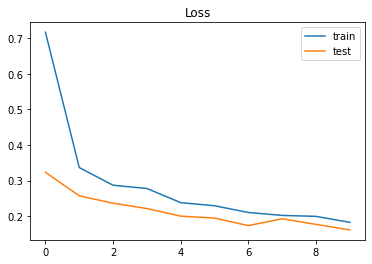

In [28]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

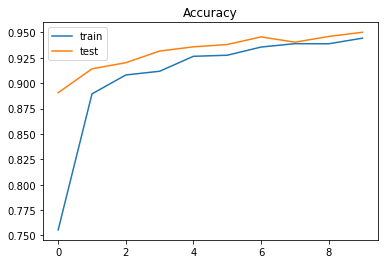

In [29]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [30]:
model.save_weights("2018A7PS0225G.h5")

In [31]:
#from keras.models import Sequential
#from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,SpatialDropout1D,GRU
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.initializers import Constant

In [32]:
#modelf=Sequential()

#modelf = Sequential()
#modelf.add(Embedding(num_words, EMBEDDING_DIM,embeddings_initializer=Constant(embedding_matrix),input_length=max_length,trainable=False))
#modelf.add(SpatialDropout1D(0.2))
#modelf.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
#modelf.add(SpatialDropout1D(0.4))
#modelf.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
#modelf.add(Dense(5, activation='softmax'))
#modelf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#epochs = 5
#batch_size = 3000

#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [33]:

#modelf.load_weights("../input/nnfl-lab3/2018A7PS0225G.h5")

In [34]:
df_test=pd.read_csv('../input/nnfl-lab-3/lab3_test.csv')

In [35]:
test_sequences = tokenizer_obj.texts_to_sequences(df_test['text'].values)
test_txt_pad = pad_sequences(test_sequences, maxlen=max_length)
 
predict = model.predict(x=test_txt_pad, verbose = 1)

 
ans = []
for arr in predict:
    ind = arr.argmax()
    ind= ind+1
    ans.append(ind)
 
df_test = df_test['index']
df_test = pd.DataFrame(df_test)
df_test['class'] = ans
 
 
df_test.to_csv('2018A7PS0225G.csv',index=False)

382/382 [==============================] - 181s 474ms/step


In [36]:
df_test

,index,class
0,0,3
1,1,1
2,2,4
3,3,2
4,4,1
...,...,...
12194,12194,1
12195,12195,1
12196,12196,1
12197,12197,1
